In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import compress

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

# import lightgbm as ltb

import scipy.stats as stats
print("Imports done.")

Imports done.


## Helper functions  

In [44]:
def load_csv(filename: str):
    df = pd.read_csv(f"data/{filename}.csv")
    return df

In [45]:
def inspect(df: pd.DataFrame):
    print(f"Shape of the dataframe: {df.shape}")
    print()
    print(f"Columns in the dataframe:\n{df.columns}")
    print()
    print(f"{df.info()}")
    print()
    # print(f"Summary: {df.describe()}")
    print(f"Missing values:\n{df.isna().sum()}")
    return

In [46]:
def name_fl(name):
    l = name.split()
    n = ' '.join((l[0], l[-1]))
    return n

In [47]:
def select_features(df: pd.DataFrame, moviesdf: pd.DataFrame):
    '''
    This function merges the given dataframes. Note that the first df must be "train" or "test" and
    the second df should be "movies".
    Note: Sentiment column is present only in "train.csv" file and not "test.csv" file.
    '''
    
    # Drop duplicates from moviesdf
#     movies_unique = moviesdf.drop_duplicates(subset=["movieid"])
    # Drop duplicates using groupby - clubs similar rows and fills in missing values better
    movies_unique = moviesdf.fillna(value=np.nan).groupby("movieid").first()

    # Merge df and movies_unique
    df_merged = pd.merge(df, movies_unique, on="movieid", how='left')
    
    # Rename "isTopCritic" column, if it exists, to "isFrequentReviewer"
    df_merged.rename(columns={"isTopCritic": "isFrequentReviewer"}, inplace=True)
    
    # Drop columns
    df_merged = df_merged.drop(columns=["title", "ratingContents", "releaseDateTheaters", "releaseDateStreaming", "distributor", "soundType"])

    # Create new columns based on reviewText
    final = df_merged.copy()
    final["reviewYN"] = np.where(final["reviewText"].isnull(), 1, 0)    # Feature engineering - adding a new column
    final["reviewWC"] = final.apply(lambda x: len(str(x["reviewText"]).split()), axis=1)    # Feature engineering - adding second new column
    
    # Clean text (replace numbers with empty string) and fill missing values in "reviewText" with empty string
    final["reviewText"] = final["reviewText"].str.replace('\d+', '', regex=True)
    final["reviewText"] = final["reviewText"].fillna("neutral")
    
    # Fill missing values in "rating", "genre", original columns with the word "Unknown"
    final["rating"] = final["rating"].fillna("Unknown")
    final["genre"] = final["genre"].fillna("Unknown")
    final["originalLanguage"] = final["originalLanguage"].fillna("Unknown")

    # Impute missing values for "audienceScore" and "runtimeMinutes" columns
    final["audienceScore"] = final["audienceScore"].fillna(final["audienceScore"].mean())
    final["runtimeMinutes"] = final["runtimeMinutes"].fillna(final["runtimeMinutes"].median())
    
    # Preprocess and impute missing values in "boxOffice" column
    final["boxOffice"] = final["boxOffice"].str[1:]
    final["boxOffice"] = final["boxOffice"].replace(to_replace={"M": "*1000000", "K": "*1000"}, regex=True)
    final["boxOffice"] = final["boxOffice"].loc[final["boxOffice"].notnull()].apply(lambda x: eval(str(x)))
    final["boxOffice"] = final["boxOffice"].fillna(final["boxOffice"].median())
    # (Optional) Replace outliers in boxOffice with median
    median = final["boxOffice"].describe()['50%']
    iqr = final["boxOffice"].describe()['75%'] - final["boxOffice"].describe()['25%']
    ll = median - (1.5*iqr)
    ul = median + (1.5*iqr)
    final.loc[final["boxOffice"] > ul, "boxOffice"] = median
    
    # Clean language names
    final["originalLanguage"].replace({"English (United Kingdom)": "English", 
                                            "English (Australia)" : "English",
                                            "French (France)": "French", 
                                            "French (Canada)": "French",
                                            "Portuguese (Brazil)": "Portuguese",
                                            "Spanish (Spain)": "Spanish"},                                         
                                            inplace=True)
    
    # Clean reviewerName column
    pre_post_fixes = {"Mr. ": "", "Mrs. ": "", "Ms. ": "", "Dr. ": "", 
                      " MD": "", " DDS": "", " DVM": "", " Jr.": "", " PhD": "", " II": "", " IV": ""}
    final["reviewerName"] = final["reviewerName"].replace(pre_post_fixes, regex=True)
    final["reviewerName"] = final["reviewerName"].apply(name_fl)

    return final

In [48]:
merged = select_features(load_csv('train'), load_csv('movies'))

In [49]:
inspect(merged)

Shape of the dataframe: (162758, 14)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director', 'boxOffice', 'reviewYN', 'reviewWC'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             162758 non-null  object 
 1   reviewerName        162758 non-null  object 
 2   isFrequentReviewer  162758 non-null  bool   
 3   reviewText          162758 non-null  object 
 4   sentiment           162758 non-null  object 
 5   audienceScore       162758 non-null  float64
 6   rating              162758 non-null  object 
 7   runtimeMinutes      162758 non-null  float64
 8   genre               162758 non-null  object 
 9   originalLanguage    162758

In [104]:
merged['movieid'].unique().shape

(16812,)

In [50]:
merged_test = select_features(load_csv('test'), load_csv('movies'))

In [51]:
inspect(merged_test)

Shape of the dataframe: (55315, 13)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director', 'boxOffice', 'reviewYN', 'reviewWC'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieid             55315 non-null  object 
 1   reviewerName        55315 non-null  object 
 2   isFrequentReviewer  55315 non-null  bool   
 3   reviewText          55315 non-null  object 
 4   audienceScore       55315 non-null  float64
 5   rating              55315 non-null  object 
 6   runtimeMinutes      55315 non-null  float64
 7   genre               55315 non-null  object 
 8   originalLanguage    55315 non-null  object 
 9   director            55315 non-null  object 
 10  boxO

## Go through movies.csv data  

In [52]:
movies = load_csv('movies')
inspect(movies)

Shape of the dataframe: (143258, 14)

Columns in the dataframe:
Index(['movieid', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-nul

In [73]:
movies.head(10)

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN
5,james_bond_courageous,James Bond Courageous,65.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic ...",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,NaN
6,rocky_balboa_elegant_jack_sparrow,Rocky Balboa Elegant Jack Sparrow,55.0,NaN,NaN,NaN,2015-10-05,88.0,Comedy,Spanish,Melanie Berube,NaN,NaN,NaN
7,evoke_darth_vader_marty_mcfly,Evoke Darth Vader Marty McFly,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bettie Edelson,NaN,NaN,NaN
8,jon_snow_e.t.,Jon Snow E.T.,NaN,NaN,NaN,NaN,NaN,123.0,Drama,English,Bessie Frame,NaN,NaN,NaN
9,glorious_quench_iron_man,Glorious Quench Iron Man,74.0,NaN,NaN,1947-04-30,2016-05-23,92.0,"Crime, Drama",English,Robert Stgermain,NaN,NaN,NaN


In [92]:
movies_unique = movies.fillna(value=np.nan).groupby("movieid").first().reset_index()
# movies_unique = movies_unique.fillna(method="ffill").reset_index()

In [95]:
inspect(movies_unique)

Shape of the dataframe: (126404, 14)

Columns in the dataframe:
Index(['movieid', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126404 entries, 0 to 126403
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               126404 non-null  object 
 1   title                 126404 non-null  object 
 2   audienceScore         66187 non-null   float64
 3   rating                13319 non-null   object 
 4   ratingContents        13319 non-null   object 
 5   releaseDateTheaters   28896 non-null   object 
 6   releaseDateStreaming  71696 non-null   object 
 7   runtimeMinutes        114448 non-null  float64
 8   genre                 116797 non-nul

In [94]:
movies_unique.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,adventure_anakin_skywalker,Adventure Anakin Skywalker,49.0,None,None,None,2014-06-17,96.0,Comedy,English,Autumn Gonzalez,None,None,None
1,adventure_anakin_skywalker_chronicles_whisper,Adventure Anakin Skywalker Chronicles Whisper,NaN,None,None,None,2018-01-16,90.0,Drama,English,Mark Machado,None,None,None
2,adventure_astonish,Adventure Astonish,40.0,None,None,None,2005-02-01,90.0,Comedy,English,Doreen Edison,None,None,Surround
3,adventure_astonish_wondrous_beneath,Adventure Astonish Wondrous Beneath,60.0,None,None,None,2018-06-24,96.0,Romance,English,Joshua Harper,None,None,None
4,adventure_aurora_epic,Adventure Aurora Epic,NaN,None,None,None,2020-04-17,60.0,Drama,English,Abel Edwards,None,None,None


In [ ]:
set(movies.columns) - set(movies_unique.columns)

{'movieid'}

In [ ]:
np.array(movies['title']).shape

(143258,)

In [ ]:
np.array(movies_unique['title']).shape

(126404,)

<AxesSubplot:ylabel='audienceScore'>

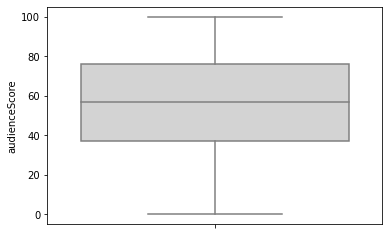

In [62]:
sns.boxplot(y=movies["audienceScore"], orient="v", color="lightgray")

<AxesSubplot:ylabel='audienceScore'>

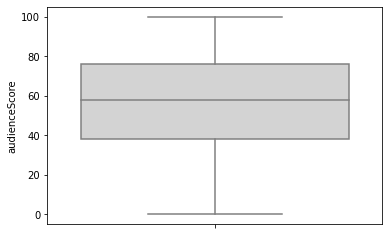

In [61]:
sns.boxplot(y=movies_unique["audienceScore"], orient="v", color="lightgray")

c:\Users\All users\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='audienceScore', ylabel='Density'>

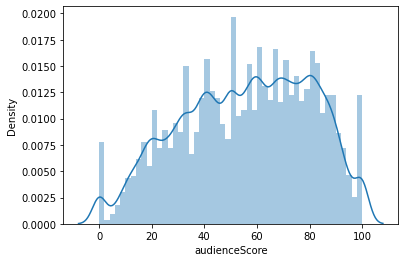

In [65]:
# Plot histogram of audienceScore  
sns.distplot(movies['audienceScore'], kde=True)

c:\Users\All users\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='audienceScore', ylabel='Density'>

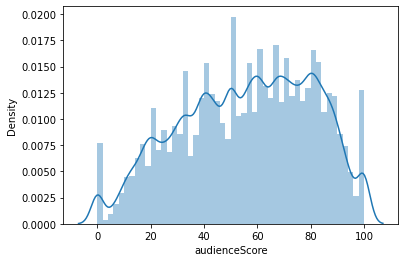

In [66]:
sns.distplot(movies_unique['audienceScore'], kde=True)


## Merge and clean   

In [188]:
def select_features(df: pd.DataFrame, moviesdf: pd.DataFrame, row_thresh_null=None):
    '''
    This function merges the given dataframes. Note that the first df must be "train" or "test" and
    the second df should be "movies".
    Note: Sentiment column is present only in "train.csv" file and not "test.csv" file.
    '''
    
    # Drop duplicates from moviesdf
#     movies_unique = moviesdf.drop_duplicates(subset=["movieid"])

    # Drop duplicates using groupby - clubs similar rows and fills in missing values better
    movies_unique = moviesdf.fillna(value=np.nan).groupby("movieid").first().reset_index()
    

    # Handle missing values in movies.csv better than just dropping duplicates?
#     movies_unique = moviesdf.copy()
#     movies_unique[["audienceScore", "runtimeMinutes"]] = movies_unique[["audienceScore", "runtimeMinutes"]].interpolate(method='linear', axis=0)
#     movies_unique = movies_unique.fillna(value=np.nan).groupby("movieid").first().fillna(method='ffill').reset_index()

    

    # Merge df and movies_unique
    df_merged = pd.merge(df, movies_unique, on="movieid", how='left')
    
    # Rename "isTopCritic" column, if it exists, to "isFrequentReviewer"
    df_merged.rename(columns={"isTopCritic": "isFrequentReviewer"}, inplace=True)
    
    # Drop columns
    # df_merged = df_merged.drop(columns=["title", "ratingContents", "releaseDateTheaters", "releaseDateStreaming", "distributor", "soundType"])
    df_merged = df_merged.drop(columns=["title", "distributor", "soundType"])
    
    # Drop rows (OPTIONAL: Uses kwarg row_thresh_null)
    if row_thresh_null != None:
        df_merged.dropna(axis=0, thresh=(df_merged.shape[1] - row_thresh_null), inplace=True)
        # df_merged.to_csv("df_merged.csv")
        

    # Create new columns based on reviewText
    final = df_merged.copy()
    final["reviewYN"] = np.where(final["reviewText"].isnull(), 1, 0)    # Feature engineering - adding a new column
    final["reviewWC"] = final.apply(lambda x: len(str(x["reviewText"]).split()), axis=1)    # Feature engineering - adding second new column
    
    # Clean text (replace numbers with empty string) and fill missing values in "reviewText" with empty string
    final["reviewText"] = final["reviewText"].str.replace('\d+', '', regex=True)
    final["reviewText"] = final["reviewText"].fillna("neutral")
    
    # Fill missing values in "rating", "genre", original columns with the word "Unknown"
    final["rating"] = final["rating"].fillna("Unknown")
    final["genre"] = final["genre"].fillna("Unknown")
    final["originalLanguage"] = final["originalLanguage"].fillna("Unknown")

    # Impute missing values for "audienceScore" and "runtimeMinutes" columns
    final["audienceScore"] = final["audienceScore"].fillna(final["audienceScore"].mean())
    final["runtimeMinutes"] = final["runtimeMinutes"].fillna(final["runtimeMinutes"].median())
    
    # Preprocess and impute missing values in "boxOffice" column
    final["boxOffice"] = final["boxOffice"].str[1:]
    final["boxOffice"] = final["boxOffice"].replace(to_replace={"M": "*1000000", "K": "*1000"}, regex=True)
    final["boxOffice"] = final["boxOffice"].loc[final["boxOffice"].notnull()].apply(lambda x: eval(str(x)))
    final["boxOffice"] = final["boxOffice"].fillna(final["boxOffice"].median())
    # (Optional) Replace outliers in boxOffice with median
    median = final["boxOffice"].describe()['50%']
    iqr = final["boxOffice"].describe()['75%'] - final["boxOffice"].describe()['25%']
    ll = median - (1.5*iqr)
    ul = median + (1.5*iqr)
    final.loc[final["boxOffice"] > ul, "boxOffice"] = median
    
    # Clean language names
    final["originalLanguage"].replace({"English (United Kingdom)": "English", 
                                            "English (Australia)" : "English",
                                            "French (France)": "French", 
                                            "French (Canada)": "French",
                                            "Portuguese (Brazil)": "Portuguese",
                                            "Spanish (Spain)": "Spanish"},                                         
                                            inplace=True)
    
    # Clean reviewerName column
    pre_post_fixes = {"Mr. ": "", "Mrs. ": "", "Ms. ": "", "Dr. ": "", 
                      " MD": "", " DDS": "", " DVM": "", " Jr.": "", " PhD": "", " II": "", " IV": ""}
    final["reviewerName"] = final["reviewerName"].replace(pre_post_fixes, regex=True)
    final["reviewerName"] = final["reviewerName"].apply(name_fl)

    # Handle 'ratingContents' column
    final["ratingContents"] = final["ratingContents"].fillna("neutral")

    # Work with 'releaseDateTheaters', releaseDateStreaming column
    final[["releaseDateTheaters", "releaseDateStreaming"]] = final[["releaseDateTheaters", "releaseDateStreaming"]].astype('datetime64[ns]')

    final["releaseDate"] = final[["releaseDateTheaters", "releaseDateStreaming"]].min(axis=1, skipna=False)
    final["releaseDate"] = final["releaseDate"].fillna(final["releaseDate"].median())


    final["releaseYear"] = final["releaseDate"].dt.year
    final["releaseMonth"] = final["releaseDate"].dt.month
    
    # Compute "releaseDiff" column and fill missing values in "releaseDiff" and (optional) replace outliers
    final["releaseDiff"] = (final["releaseDateStreaming"] - final["releaseDateTheaters"]) / np.timedelta64(1, 'D')
    final["releaseDiff"] = final["releaseDiff"].fillna(final["releaseDiff"].median())
    # median = final["releaseDiff"].describe()['50%']
    # iqr = final["releaseDiff"].describe()['75%'] - final["releaseDiff"].describe()['25%']
    # ll = median - (1.5*iqr)
    # ul = median + (1.5*iqr)
    # final.loc[final["releaseDiff"] > ul, "releaseDiff"] = median
    # final.loc[final["releaseDiff"] < ll, "releaseDiff"] = median
    final.to_csv("df_merged.csv")

    
    return final

In [127]:
merged.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'reviewYN',
       'reviewWC'],
      dtype='object')

In [189]:
merged = select_features(load_csv("train"), load_csv("movies"), row_thresh_null=None)
inspect(merged)

Shape of the dataframe: (162758, 21)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'reviewYN',
       'reviewWC', 'releaseDate', 'releaseYear', 'releaseMonth',
       'releaseDiff'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   movieid               162758 non-null  object        
 1   reviewerName          162758 non-null  object        
 2   isFrequentReviewer    162758 non-null  bool          
 3   reviewText            162758 non-null  object        
 4   sentiment             162758 non-null  object        
 5   audienceScore   

In [185]:
merged['releaseDate'].describe(datetime_is_numeric=True)

count                           162758
mean     2008-02-12 20:18:40.800206336
min                1913-07-31 00:00:00
25%                2005-01-25 00:00:00
50%                2011-06-10 00:00:00
75%                2016-08-19 00:00:00
max                2023-04-14 00:00:00
Name: releaseDate, dtype: object

In [186]:
merged['releaseYear'].describe()

count    162758.000000
mean       2007.604837
std          14.774821
min        1913.000000
25%        2005.000000
50%        2011.000000
75%        2016.000000
max        2023.000000
Name: releaseYear, dtype: float64

In [187]:
merged['releaseMonth'].describe()


count    162758.000000
mean          6.701840
std           3.229472
min           1.000000
25%           4.000000
50%           6.000000
75%          10.000000
max          12.000000
Name: releaseMonth, dtype: float64

In [164]:
merged["releaseDiff"].describe()

count    162758.000000
mean       1515.733734
std        4629.012982
min      -12619.000000
25%          88.000000
50%         123.000000
75%         221.000000
max       38922.000000
Name: releaseDiff, dtype: float64

<AxesSubplot:ylabel='releaseDiff'>

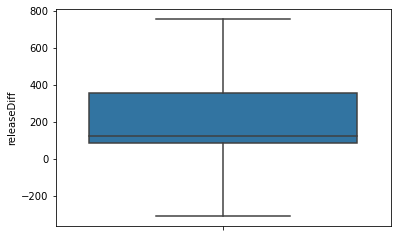

In [151]:
sns.boxplot(y=merged['releaseDiff'], showfliers=False)

In [113]:
merged['ratingContents'].value_counts()

neutral                                                                    44587
['Language']                                                                2832
['Some Language']                                                           1213
['Sexual Content', 'Language']                                               957
['Brief Strong Language']                                                    861
                                                                           ...  
['Language Throughout', 'Drug Use', 'A Brief Nude Image', 'Violence']          1
['Innuendo', 'Some Sexual Content', 'Partial Nudity']                          1
['Thematic Material', 'Some Violence', 'Disturbing Images']                    1
['Sexual Content', 'Drug Use', 'Nudity', 'Language', 'Strong Violence']        1
['Thematic Material', 'Hardships', 'Peril', 'Language']                        1
Name: ratingContents, Length: 5158, dtype: int64

In [131]:
merged['releaseDateTheaters'].head()

0   2022-10-21
1   2010-02-12
2   2018-11-21
3   2014-07-25
4   2003-01-17
Name: releaseDateTheaters, dtype: datetime64[ns]

## Check groupby and fillna methods on dummy.csv file  

In [ ]:
dummy = pd.read_csv('dummy_large.csv')
dummy

,movie_id,audience_score,run_time,genre,release_date,director,language,soundtype,rating
0,1,8.5,120.0,Action,2021-05-15,John Doe,English,Dolby Digital,PG-13
1,1,NaN,NaN,Comedy,NaN,Jane Smith,NaN,NaN,NaN
2,1,NaN,110.0,NaN,NaN,NaN,English,DTS-HD,NaN
3,2,7.9,NaN,NaN,2020-11-20,NaN,NaN,Dolby Digital,NaN
4,2,7.4,95.0,NaN,2020-11-20,NaN,NaN,Dolby Digital,NaN
5,3,6.3,105.0,NaN,2019-09-10,Alice Johnson,NaN,DTS-HD,NaN
6,3,6.1,NaN,NaN,2019-09-10,Alice Johnson,NaN,DTS-HD,NaN
7,4,8.0,NaN,Action,NaN,Jane Smith,English,Dolby Digital,NaN
8,4,7.2,100.0,NaN,2018-07-25,Jane Smith,NaN,Dolby Digital,NaN
9,5,NaN,130.0,Action,2017-12-01,John Doe,NaN,Dolby Digital,NaN


In [ ]:
gb1 = dummy.groupby('movie_id').first()
gb1

,audience_score,run_time,genre,release_date,director,language,soundtype,rating
movie_id,,,,,,,,
1,8.5,120.0,Action,2021-05-15,John Doe,English,Dolby Digital,PG-13
2,7.9,95.0,None,2020-11-20,None,None,Dolby Digital,None
3,6.3,105.0,None,2019-09-10,Alice Johnson,None,DTS-HD,None
4,8.0,100.0,Action,2018-07-25,Jane Smith,English,Dolby Digital,None
5,8.0,130.0,Action,2017-12-01,John Doe,English,Dolby Digital,PG-13
6,6.9,135.0,Drama,2022-03-05,Emily Adams,English,Dolby Atmos,PG-13
7,7.1,110.0,Comedy,2016-09-30,Jane Smith,English,Dolby Digital,PG-13
8,7.8,105.0,Romance,2015-05-12,Alice Johnson,English,DTS-HD,PG
9,NaN,120.0,Drama,2020-02-18,John Doe,None,Dolby Digital,R


In [ ]:
gb2 = dummy.groupby('movie_id').any()
gb2.head()

,audience_score,run_time,genre,release_date,director,language,soundtype,rating
movie_id,,,,,,,,
1,True,True,True,True,True,True,True,True
2,True,True,False,True,False,False,True,False
3,True,True,False,True,True,False,True,False
4,True,True,True,True,True,True,True,False
5,True,True,True,True,True,True,True,True


In [ ]:
gb3 = dummy.groupby('movie_id').first().fillna(method='ffill').reset_index()
gb3

,movie_id,audience_score,run_time,genre,release_date,director,language,soundtype,rating
0,1,8.5,120.0,Action,2021-05-15,John Doe,English,Dolby Digital,PG-13
1,2,7.9,95.0,Action,2020-11-20,John Doe,English,Dolby Digital,PG-13
2,3,6.3,105.0,Action,2019-09-10,Alice Johnson,English,DTS-HD,PG-13
3,4,8.0,100.0,Action,2018-07-25,Jane Smith,English,Dolby Digital,PG-13
4,5,8.0,130.0,Action,2017-12-01,John Doe,English,Dolby Digital,PG-13
5,6,6.9,135.0,Drama,2022-03-05,Emily Adams,English,Dolby Atmos,PG-13
6,7,7.1,110.0,Comedy,2016-09-30,Jane Smith,English,Dolby Digital,PG-13
7,8,7.8,105.0,Romance,2015-05-12,Alice Johnson,English,DTS-HD,PG
8,9,7.8,120.0,Drama,2020-02-18,John Doe,English,Dolby Digital,R
9,10,6.0,95.0,Comedy,2019-08-15,Emily Adams,English,DTS-HD,PG


In [70]:
interp = dummy.interpolate(method='spline', order=2, axis=0)
interp

,movie_id,audience_score,run_time,genre,release_date,director,language,soundtype,rating
0,1,8.500000,120.000000,Action,2021-05-15,John Doe,English,Dolby Digital,PG-13
1,1,7.629783,151.611592,Comedy,NaN,Jane Smith,NaN,NaN,NaN
2,1,7.581209,110.000000,NaN,NaN,NaN,English,DTS-HD,NaN
3,2,7.900000,67.136740,NaN,2020-11-20,NaN,NaN,Dolby Digital,NaN
4,2,7.400000,95.000000,NaN,2020-11-20,NaN,NaN,Dolby Digital,NaN
5,3,6.300000,105.000000,NaN,2019-09-10,Alice Johnson,NaN,DTS-HD,NaN
6,3,6.100000,75.420421,NaN,2019-09-10,Alice Johnson,NaN,DTS-HD,NaN
7,4,8.000000,73.721513,Action,NaN,Jane Smith,English,Dolby Digital,NaN
8,4,7.200000,100.000000,NaN,2018-07-25,Jane Smith,NaN,Dolby Digital,NaN
9,5,7.300280,130.000000,Action,2017-12-01,John Doe,NaN,Dolby Digital,NaN


In [74]:
interp2 = movies.interpolate(method='linear', axis=0)
interp2.head(10)

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,46.5,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN
5,james_bond_courageous,James Bond Courageous,65.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic ...",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,NaN
6,rocky_balboa_elegant_jack_sparrow,Rocky Balboa Elegant Jack Sparrow,55.0,NaN,NaN,NaN,2015-10-05,88.0,Comedy,Spanish,Melanie Berube,NaN,NaN,NaN
7,evoke_darth_vader_marty_mcfly,Evoke Darth Vader Marty McFly,88.0,NaN,NaN,NaN,NaN,105.5,NaN,NaN,Bettie Edelson,NaN,NaN,NaN
8,jon_snow_e.t.,Jon Snow E.T.,81.0,NaN,NaN,NaN,NaN,123.0,Drama,English,Bessie Frame,NaN,NaN,NaN
9,glorious_quench_iron_man,Glorious Quench Iron Man,74.0,NaN,NaN,1947-04-30,2016-05-23,92.0,"Crime, Drama",English,Robert Stgermain,NaN,NaN,NaN


In [75]:
tvec = TfidfVectorizer(ngram_range=(1,1))
tvec

TfidfVectorizer()

In [79]:
mov_rc = movies["ratingContents"].fillna(value="Unknown")
tvec.fit(mov_rc)

TfidfVectorizer()

In [81]:
tvec.vocabulary_.keys()

dict_keys(['unknown', 'injury', 'images', 'brief', 'drug', 'use', 'thematic', 'elements', 'language', 'partial', 'nudity', 'peril', 'some', 'sexual', 'content', 'material', 'mild', 'crude', 'humor', 'violence', 'sex', 'related', 'dialogue', 'teen', 'partying', 'bloody', 'horror', 'pervasive', 'strong', 'extended', 'sequences', 'of', 'action', 'suggestive', 'references', 'rude', 'and', 'throughout', 'sexuality', 'sensuality', 'underage', 'drinking', 'scene', 'unsettling', 'smoking', 'graphic', 'gore', 'terror', 'martial', 'arts', 'intense', 'fantasy', 'violent', 'mature', 'disturbing', 'bullying', 'war', 'accident', 'scenes', 'rape', 'gruesome', 'alcohol', 'tobacco', 'racial', 'slurs', 'imagery', 'brutal', 'lewd', 'assault', 'torture', 'human', 'trafficking', 'frightening', 'adventure', 'sci', 'fi', 'grisly', 'dangerous', 'risky', 'behavior', 'situation', 'nude', 'involving', 'crucifixion', 'image', 'scary', 'cntent', 'disaster', 'fight', 'reference', 'heavy', 'dancing', 'substance', 'a